In [1]:
import pandas as pd
import numpy as np
import wrangle2
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Select a dataset with a continuous target variable.  Be sure your data is prepared (no missing values, numeric datatypes) 

In [2]:
df = pd.read_csv('zillow.csv')

In [3]:
df = df.dropna()

# ...and split into samples.

In [4]:
train, validate, test = wrangle2.my_split(df)

In [5]:
train.shape, validate.shape, test.shape

((1112646, 8), (370882, 8), (370883, 8))

In [32]:
train.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
parcelid,1112646.00,13032249.06,4172112.80,10711726.00,11698365.25,12617766.50,14036867.75,168183616.00
bedroomcnt,1112646.00,3.21,0.78,2.00,3.00,3.00,4.00,5.00
bathroomcnt,1112646.00,2.05,0.71,1.00,2.00,2.00,2.50,4.00
calculatedfinishedsquarefeet,1112646.00,1654.27,564.73,1.00,1232.00,1548.00,1988.00,3410.00
taxvaluedollarcnt,1112646.00,327972.92,199008.07,22.00,173923.00,296638.00,452511.00,950940.00
yearbuilt,1112646.00,1959.46,20.55,1801.00,1949.00,1957.00,1972.00,2016.00
taxamount,1112646.00,4069.51,2242.86,16.48,2366.55,3746.93,5488.95,10377.84
fips,1112646.00,6048.33,20.51,6037.00,6037.00,6037.00,6059.00,6111.00


# Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

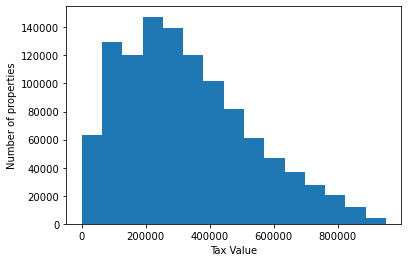

In [7]:
# plot distribution of target
plt.hist(train.taxvaluedollarcnt, bins=15)
plt.xlabel("Tax Value")
plt.ylabel("Number of properties")
plt.show()

### Target is right-skewed

In [8]:
# create scaler for features
scaler = MinMaxScaler()

# create dataframe for scaled values, and add columns that won't initially be scaled
s_train = train[['parcelid', 'fips', 'taxvaluedollarcnt']]
s_validate = validate[['parcelid', 'fips', 'taxvaluedollarcnt']]
s_test = test[['parcelid', 'fips', 'taxvaluedollarcnt']]

In [9]:
# scale features and add them to scaled dataframe

s_train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']] = scaler.fit_transform(train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']])
s_validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']] = scaler.transform(validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']])
s_test[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']] = scaler.transform(test[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']])

In [10]:
# create target scaler and scale target variable
target_scaler = QuantileTransformer(output_distribution='normal')

s_train[['target']] = target_scaler.fit_transform(train[['taxvaluedollarcnt']])
s_validate[['target']] = target_scaler.transform(validate[['taxvaluedollarcnt']])
s_test[['target']] = target_scaler.transform(test[['taxvaluedollarcnt']])

In [11]:
features = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']

In [12]:
# create X and y dataframes
X_train = s_train[features]
X_validate = s_validate[features]
X_test = s_test[features]

y_train = s_train['taxvaluedollarcnt']
y_validate = s_validate['taxvaluedollarcnt']
y_test = s_test['taxvaluedollarcnt']

In [13]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# append scaled values
y_train['target'] = s_train['target']
y_validate['target'] = s_validate['target']
y_test['target'] = s_test['target']

In [14]:
# 1. Predict value_pred_mean
value_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

# 2. compute value_pred_median
value_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

# 3. RMSE of value_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of value_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  199007.98 
Validate/Out-of-Sample:  198689.0
RMSE using Median
Train/In-Sample:  201459.81 
Validate/Out-of-Sample:  201114.79


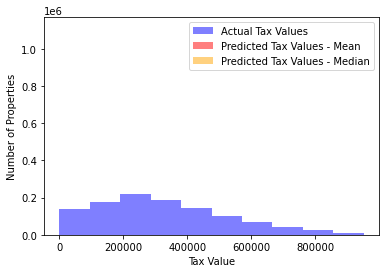

In [15]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_train.value_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Values - Mean")
plt.hist(y_train.value_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Values - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

# Linear Regression

In [16]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train['target'])

# predict train
y_train['value_pred_lm'] = lm.predict(X_train)
y_train['value_pred_lm'] = target_scaler.inverse_transform(y_train[['value_pred_lm']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_lm)**(1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate)
y_validate['value_pred_lm'] = target_scaler.inverse_transform(y_validate[['value_pred_lm']])

# evaluate: rmse
rmse_val = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  180765.5621834925 
Validation/Out-of-Sample:  201114.7911546136


# LassoLars

In [17]:
# create the model object
lars = LassoLars(alpha=.9)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train['target'])

# predict train
y_train['value_pred_llars'] = lars.predict(X_train)
y_train['value_pred_llars'] = target_scaler.inverse_transform(y_train[['value_pred_llars']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_llars)**(1/2)

# predict validate
y_validate['value_pred_llars'] = lars.predict(X_validate)
y_validate['value_pred_llars'] = target_scaler.inverse_transform(y_validate[['value_pred_llars']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_llars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  201454.199291261 
Validation/Out-of-Sample:  201109.20645029203


# TweedieRegressor (GLM)

In [18]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0) # changed power to 0 since we normalized the target

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train['target'])

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)
y_train['value_pred_glm'] = target_scaler.inverse_transform(y_train[['value_pred_glm']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)
y_validate['value_pred_glm'] = target_scaler.inverse_transform(y_validate[['value_pred_glm']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  180766.6465694584 
Validation/Out-of-Sample:  180623.52351079162


In [19]:
# un-transform X_train
X_train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]  = scaler.inverse_transform(X_train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']])

In [20]:
# un-transform X_validate 
X_validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]  = scaler.inverse_transform(X_validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']])
# un-transform X_train
X_test[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]  = scaler.inverse_transform(X_test[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']])

# Polynomial Regression

In [21]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [22]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.target)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)
y_train['value_pred_lm2'] = target_scaler.inverse_transform(y_train[['value_pred_lm2']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)
y_validate['value_pred_lm2'] = target_scaler.inverse_transform(y_validate[['value_pred_lm2']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  180375.90496300336 
Validation/Out-of-Sample:  180249.5116176277


# Evaluate

In [23]:
y_validate.head()

,taxvaluedollarcnt,target,value_pred_mean,value_pred_median,value_pred_lm,value_pred_llars,value_pred_glm,value_pred_lm2
890297,357170.0,0.285028,327972.920972,296638.0,394019.859755,296674.085399,394032.394573,392746.568330
404564,79272.0,-1.325676,327972.920972,296638.0,262554.566739,296674.085399,262539.193772,254555.688216
848374,640000.0,1.372454,327972.920972,296638.0,214556.880951,296674.085399,214524.336519,217230.440464
411315,606609.0,1.249333,327972.920972,296638.0,429705.556661,296674.085399,429660.900685,429260.101120
1736144,111380.0,-1.041453,327972.920972,296638.0,279216.794707,296674.085399,279183.437656,284383.340895


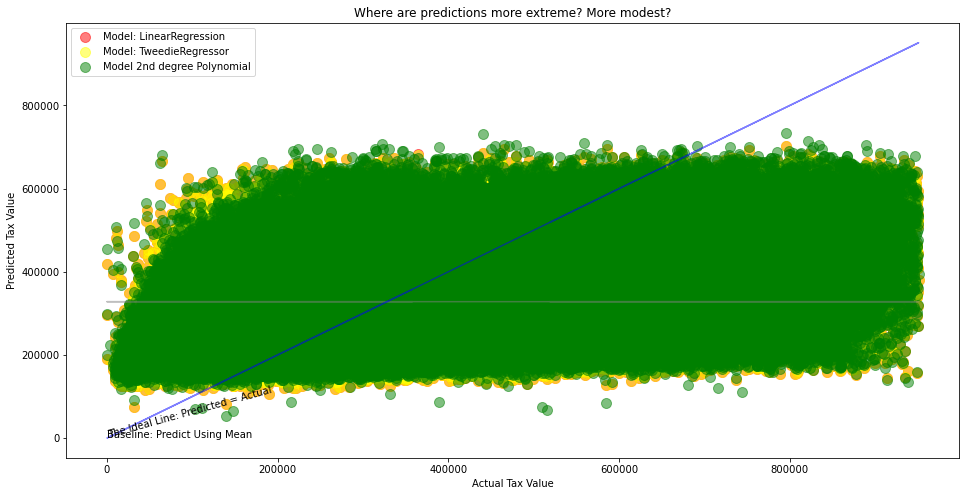

In [24]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


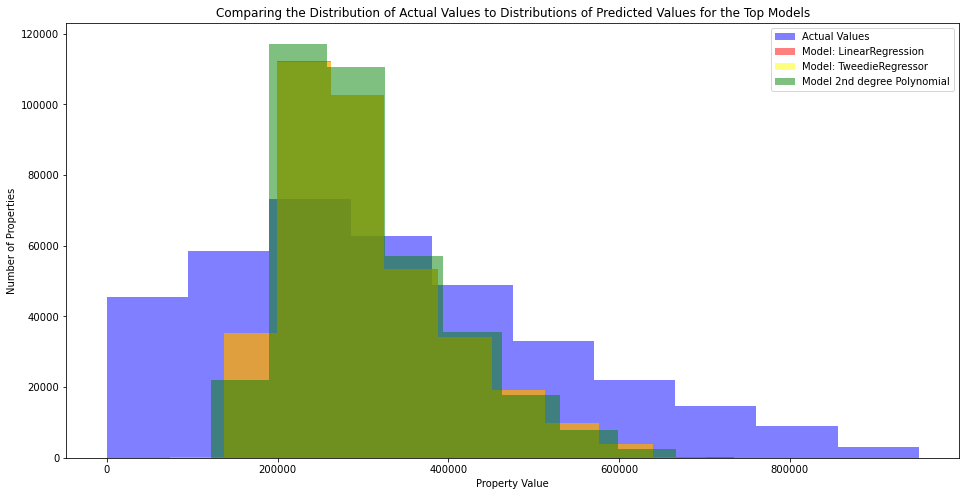

In [25]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Values")
plt.hist(y_validate.value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Property Value")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()

# Model Selection & Out-of-Sample Evaluation

In [29]:
y_test = pd.DataFrame(y_test)


# predict on test
y_test['value_pred_lm'] = lm.predict(s_test[features])
y_test['value_pred_lm'] = target_scaler.inverse_transform(y_test[['value_pred_lm']])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.value_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  180934.95117730467
